In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
from timm import create_model
from IPython.display import display
import gc

from fastai.vision.all import *

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg



There are 9912 images

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774553

There are 100 unique values of Pawpularity score



0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

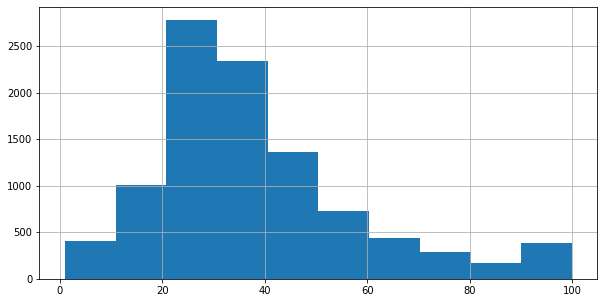

In [2]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8                       # was 32

# def get_train_df():
dataset_path = Path('../input/petfinder-pawpularity-score/')
display(dataset_path.ls())

train_df = pd.read_csv(dataset_path/'train.csv')
print()
display(train_df.head())

train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
print()
display(train_df.head())
#     return train_df

# train_df = get_train_df()
len_df = len(train_df)
print()
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize = (10, 5))
print()
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print()
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

train_df['norm_score'] = train_df['Pawpularity']/100
print()
display(train_df['norm_score'])

540 960


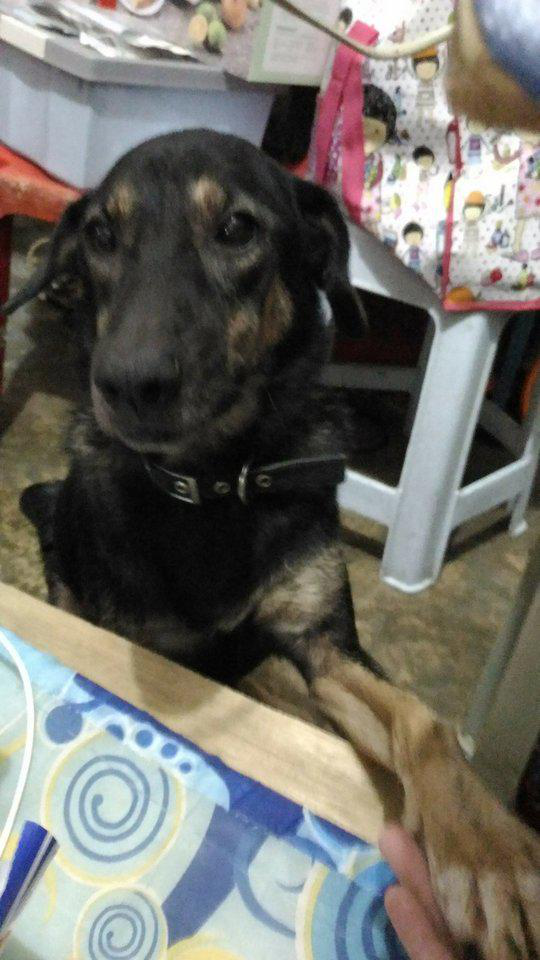

In [3]:
im = Image.open(train_df['path'][0])
width, height = im.size
print(width,height)
im

In [4]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

44



<AxesSubplot:>

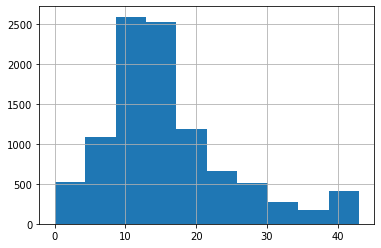

In [5]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
print(num_bins)

train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
print()
display(train_df['bins'].hist())

<AxesSubplot:>

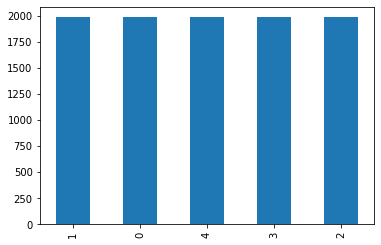

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1

N_FOLDS = 5         #was 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')
train_df.fold.value_counts().plot.bar()

In [7]:
display(train_df[train_df['fold']==0].head())
display(train_df[train_df['fold']==1].head())

display(train_df[train_df['fold']==0]['bins'].value_counts())
print("a strage split line -------------------------------------------")
display(train_df[train_df['fold']==1]['bins'].value_counts())

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
16,0,0,1,1,0,0,0,0,0,0,0,0,50,../input/petfinder-pawpularity-score/train/0a12576d99ec278f415c51f47279e89a.jpg,0.50,21,0
17,0,1,1,1,0,0,0,0,0,0,0,0,36,../input/petfinder-pawpularity-score/train/f3691bb7204b3e84ff7a879cef2a0da8.jpg,0.36,15,0
21,0,1,1,1,0,0,0,0,0,0,0,0,11,../input/petfinder-pawpularity-score/train/b4ebd690c2b69803b1cd38786c8b7bfc.jpg,0.11,4,0
23,0,1,1,1,0,0,0,0,0,0,0,0,55,../input/petfinder-pawpularity-score/train/ab5602ec4002932525238ec80e828d0e.jpg,0.55,23,0
24,0,1,1,1,0,0,0,0,1,1,0,0,31,../input/petfinder-pawpularity-score/train/b62c7148e72cc49d0ee89c4a523d56be.jpg,0.31,13,0


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
6,0,1,1,1,0,0,0,0,1,0,0,0,28,../input/petfinder-pawpularity-score/train/656ad875d187766a5e522b841634662a.jpg,0.28,11,1
10,0,1,1,1,0,0,0,0,1,0,0,0,27,../input/petfinder-pawpularity-score/train/50ea6ec9af58dd9f0966e1eae7436ebe.jpg,0.27,11,1
13,0,1,1,1,0,1,0,1,0,0,1,0,24,../input/petfinder-pawpularity-score/train/c0ecfb6bb668beff951de197f547ffab.jpg,0.24,10,1
18,0,1,1,1,0,1,0,0,0,0,0,0,40,../input/petfinder-pawpularity-score/train/f1a6875dbea3d4f91d04907682407493.jpg,0.40,17,1
26,0,0,0,1,0,0,0,0,0,0,0,0,19,../input/petfinder-pawpularity-score/train/ae3ab9856c8aa41f634096647d9e7171.jpg,0.19,7,1


11    187
15    140
12    125
13    120
10    108
9      98
14     97
7      84
20     75
17     74
8      72
16     72
18     68
43     61
19     51
23     50
21     42
27     35
0      34
6      33
22     32
4      31
5      29
25     25
24     25
31     23
26     21
28     19
3      15
1      14
30     13
29     13
32     12
33     11
35     11
2      11
34      9
40      8
38      8
36      8
37      6
41      5
42      4
39      4
Name: bins, dtype: int64

a strage split line -------------------------------------------


11    187
15    140
12    125
13    120
10    108
9      98
14     97
7      84
20     75
17     74
8      72
16     72
18     69
43     60
19     51
23     50
21     42
27     35
0      34
22     32
6      32
4      31
5      29
24     25
25     25
31     22
26     21
28     19
3      15
1      14
29     14
30     13
35     12
33     11
2      11
32     11
34     10
38      8
36      8
40      8
37      6
41      5
39      4
42      4
Name: bins, dtype: int64

In [8]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [9]:
#Valid Kfolder size
fold = 0

the_data = get_data(fold)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

SuggestedLRs(valley=5.477225568029098e-05)

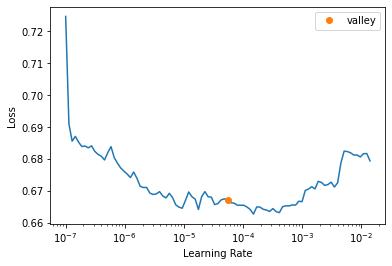

In [10]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)             #was-2

In [11]:
# all_preds = []

# for i in range(N_FOLDS):
#     print(f'Fold {i} results')
#     learn = get_learner(fold_num=i)
#     learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
#     learn.recorder.plot_loss()

#     learn = learn.to_fp32()
# #     learn.export(f'model_fold_{i}.pkl')
#     learn.save(f'model_fold_{i}.pkl')
    
#     dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                    valid_pct=0.2, #80-20 train-validation random split
#                                    seed=999, #seed
#                                    fn_col='path', #filename/path is in the second column of the DataFrame
#                                    label_col='norm_score', #label is in the first column of the DataFrame
#                                    y_block=RegressionBlock, #The type of target
#                                    bs=BATCH_SIZE, #pass in batch size
#                                    num_workers=8,
#                                    item_tfms=Resize(224), #pass in item_tfms
#                                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
#     test_dl = dls.test_dl(test_df)
#     preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
#     all_preds.append(preds)
    
#     del learn
#     torch.cuda.empty_cache()
#     gc.collect()

In [12]:
# all_preds
# np.mean(np.stack(all_preds*100))

# sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
# preds = np.mean(np.stack(all_preds), axis=0)
# sample_df['Pawpularity'] = preds*100
# sample_df.to_csv('submission.csv',index=False)

# display(pd.read_csv('submission.csv').head())

In [13]:
# path = './models'
learn1 = load_learner('../input/petfinder/model_fold_2.pkl')

In [14]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [15]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [16]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
       valid_pct=0.2, #80-20 train-validation random split
       seed=999, #seed
       fn_col='path', #filename/path is in the second column of the DataFrame
       label_col='norm_score', #label is in the first column of the DataFrame
       y_block=RegressionBlock, #The type of target
       bs=8,                                       #was32, #pass in batch size
       num_workers=8,
       item_tfms=Resize(224), #pass in item_tfms
       batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
test_dl = dls.test_dl(test_df)

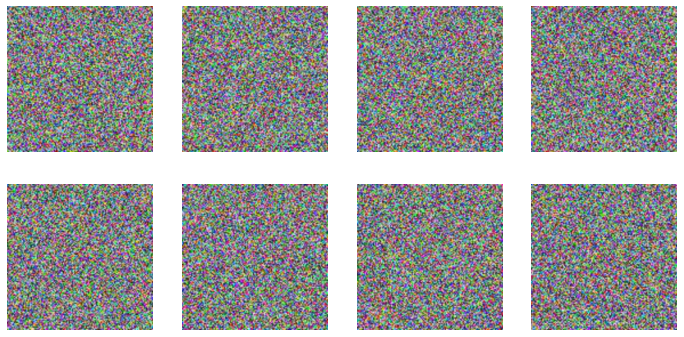

In [17]:
test_dl.show_batch()

In [18]:
preds, _ = learn1.tta(dl=test_dl, n=5, beta=0)

In [19]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['Pawpularity'] = preds.float().numpy()*100
sample_df.to_csv('submission.csv',index=False)

pd.read_csv('submission.csv').head()
display(pd.read_csv('submission.csv').head())

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,47.344345
1,43a2262d7738e3d420d453815151079e,48.625890
2,4e429cead1848a298432a0acad014c9d,48.495327
3,80bc3ccafcc51b66303c2c263aa38486,48.433050
4,8f49844c382931444e68dffbe20228f4,45.751700
